### Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import yfinance as yf
import datetime as dt

### Sentiment Index
Source: https://www.frbsf.org/economic-research/indicators-data/daily-news-sentiment-index/

In [3]:
#Sample period

start = dt.datetime(1988,12,1)
end = dt.datetime(2021,11,30)

In [4]:
#Reading data and slicing dataframe to match sample period

sentiment_indicator = pd.read_excel("news_sentiment_data.xlsx", sheet_name='Data', index_col='date').loc[start:end]
sentiment_indicator

,News Sentiment
date,
1988-12-01,0.041998
1988-12-02,0.028742
1988-12-03,0.034444
1988-12-04,0.057563
1988-12-05,0.051180
...,...
2021-11-24,0.067577
2021-11-25,0.055250
2021-11-26,0.057000


<AxesSubplot:xlabel='date'>

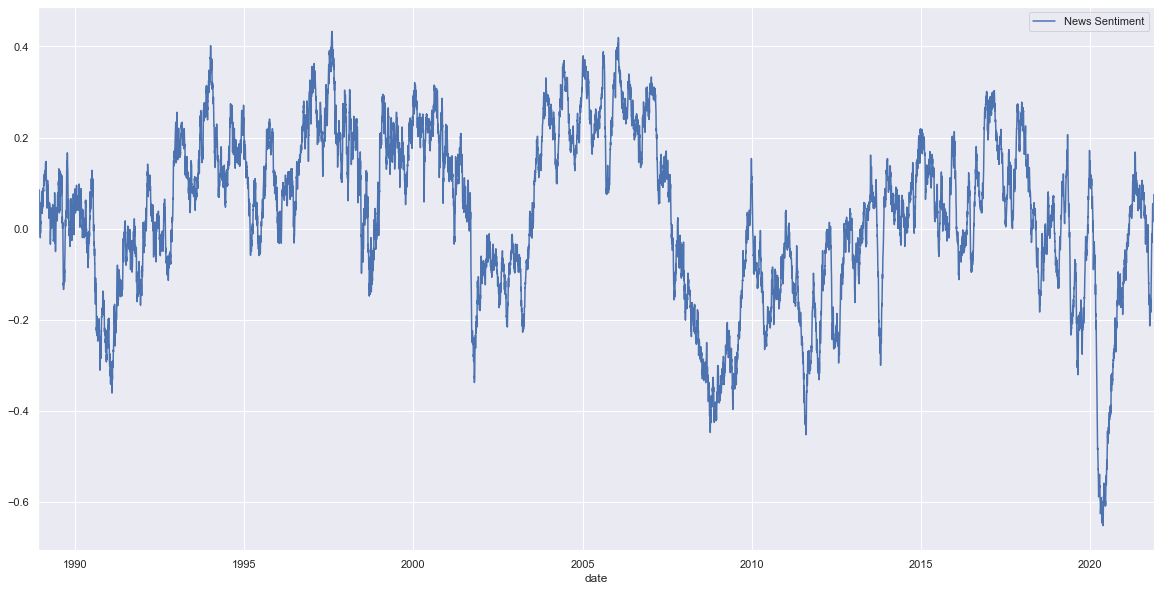

In [5]:
#Plotting the sentiment time-series

sentiment_indicator.plot(figsize=(20,10))

### National Bureau of Economic Research (NBER) Recession Indicators for the United States

Source: https://fred.stlouisfed.org/series/USREC

In [6]:
#Reading excel dataset
recession_indicator = pd.read_csv('USRECDM.csv', index_col='DATE')

In [7]:
#Converting date index to datetime data type
recession_indicator.index = pd.to_datetime(recession_indicator.index)

In [8]:
#Dataframe slicing 
recession_indicator = recession_indicator.loc[start:end]

In [9]:
recession_indicator

,USRECDM
DATE,
1988-12-01,0
1988-12-02,0
1988-12-03,0
1988-12-04,0
1988-12-05,0
...,...
2021-11-26,0
2021-11-27,0
2021-11-28,0


In [10]:
#Concatenation of the two series

sentiment_index = pd.concat([sentiment_indicator, recession_indicator], axis=1)

In [11]:
#Renaming the recession indicator
sentiment_index = sentiment_index.rename(columns={'USRECDM':'Recession Indicator'})

In [12]:
#Looking for null values
sentiment_index.isnull().sum()

News Sentiment         2
Recession Indicator    0
dtype: int64

In [13]:
#Drop null values
sentiment_index = sentiment_index.dropna()

In [14]:
sentiment_index

,News Sentiment,Recession Indicator
1988-12-01,0.041998,0
1988-12-02,0.028742,0
1988-12-03,0.034444,0
1988-12-04,0.057563,0
1988-12-05,0.051180,0
...,...,...
2021-11-24,0.067577,0
2021-11-25,0.055250,0
2021-11-26,0.057000,0
2021-11-27,0.040627,0


### Plotting the Sentiment Index against the NBER recession dates

The purpose of plotting the recession indicator as an overlay against the sentiment index is so that when we generate early warning signals in the next section, we can visually assess the effectiveness of the said signals in warning us of an imminent recession.

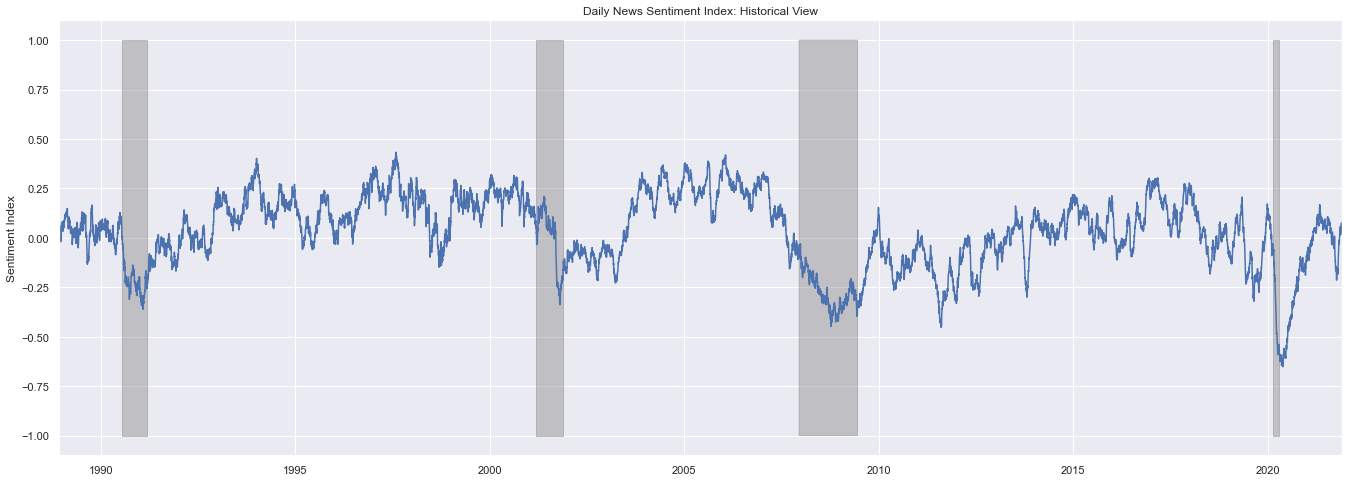

In [15]:
sentiment_index['News Sentiment'].plot(figsize=(23,8)).fill_between(sentiment_index.index,
                                                       -1,
                                                       1, 
                                                       where= sentiment_index['Recession Indicator'] > 0.5,
                color='grey', alpha=0.4)

plt.ylabel('Sentiment Index')
plt.title('Daily News Sentiment Index: Historical View')
plt.show()

### Generating Early Warning Signals (EWS)

We assess whether our sentiment indices trigger EWS ahead of the financial crises. As such, an EWS is triggered each time there is a spike, defined as follows:

1. For every point in time (i.e. everyday over sample period) we calculate a backward looking average of 500 days - we decided to settle on the mentioned window period as it offered the best signals (i.e. signals that best covered the recession dates)
2. Then, we assess whether the index is above 2 standard deviations from the average

Source: https://www.imf.org/en/Publications/WP/Issues/2019/12/06/News-based-Sentiment-Indicators-48740

In [16]:
#Calculating SMA values (window = 500)

def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

sentiment_index['sma_500'] = sma(sentiment_index['News Sentiment'], 500)
sentiment_index.tail()

,News Sentiment,Recession Indicator,sma_500
2021-11-24,0.067577,0,-0.078027
2021-11-25,0.055250,0,-0.077007
2021-11-26,0.057000,0,-0.075950
2021-11-27,0.040627,0,-0.074967
2021-11-28,0.050691,0,-0.073947


In [17]:
#Calculating Bollinger Bands(upper and lower)

def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

sentiment_index['upper_bb'], sentiment_index['lower_bb'] = bb(sentiment_index['News Sentiment'], sentiment_index['sma_500'], 500)
sentiment_index.tail()

,News Sentiment,Recession Indicator,sma_500,upper_bb,lower_bb
2021-11-24,0.067577,0,-0.078027,0.230130,-0.386183
2021-11-25,0.055250,0,-0.077007,0.229524,-0.383537
2021-11-26,0.057000,0,-0.075950,0.228770,-0.380669
2021-11-27,0.040627,0,-0.074967,0.228072,-0.378005
2021-11-28,0.050691,0,-0.073947,0.227337,-0.375231


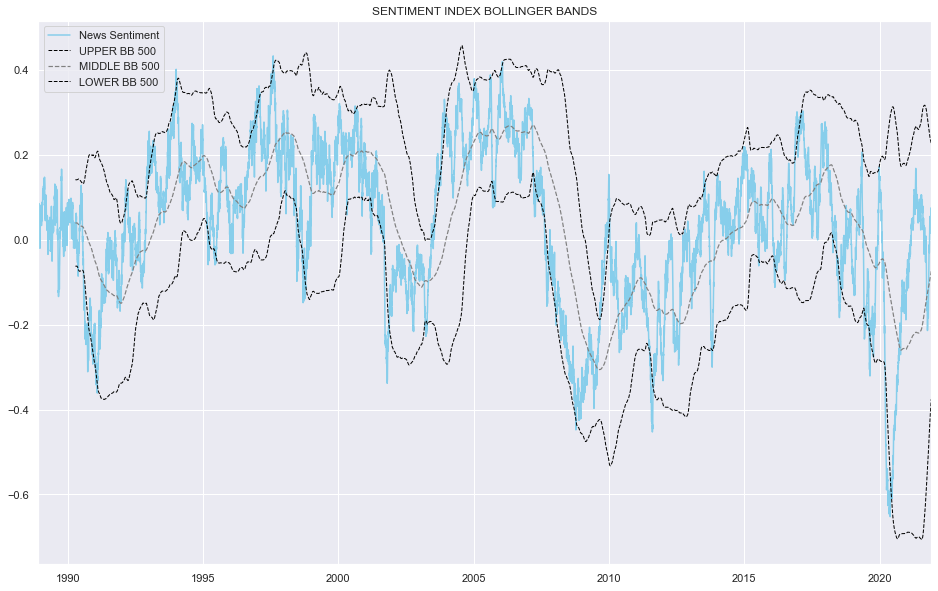

In [18]:
#Plotting Bollinger Bands values

sentiment_index['News Sentiment'].plot(label = 'News Sentiment', color = 'skyblue', figsize=(16,10))
sentiment_index['upper_bb'].plot(label = 'UPPER BB 500', linestyle = '--', linewidth = 1, color = 'black')
sentiment_index['sma_500'].plot(label = 'MIDDLE BB 500', linestyle = '--', linewidth = 1.2, color = 'grey')
sentiment_index['lower_bb'].plot(label = 'LOWER BB 500', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc = 'upper left')
plt.title('SENTIMENT INDEX BOLLINGER BANDS')
plt.show()

In [19]:
#Generating the Bollinger Band Signals => signals are generated as they just cross the band

def implement_bb_strategy(data, lower_bb, upper_bb):
    risk_on = []
    risk_off = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:   #IF PREV_SENTIMENT > PREV_LOWERBB & CUR_STOCK < CUR_LOWER_BB => RISK-ON
            if signal != 1:
                risk_on.append(data[i])
                risk_off.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                risk_on.append(np.nan)
                risk_off.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:  #IF PREV_SENTIMENT < PREV_UPPERBB & CUR_STOCK > CUR_UPPER_BB => RISK-OFF
            if signal != -1:
                risk_on.append(np.nan)
                risk_off.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                risk_on.append(np.nan)
                risk_off.append(np.nan)
                bb_signal.append(0)
        else:
            risk_on.append(np.nan)
            risk_off.append(np.nan)
            bb_signal.append(0)
            
    return risk_on, risk_off, bb_signal

risk_on, risk_off, bb_signal = implement_bb_strategy(sentiment_index['News Sentiment'], sentiment_index['lower_bb'], sentiment_index['upper_bb'])


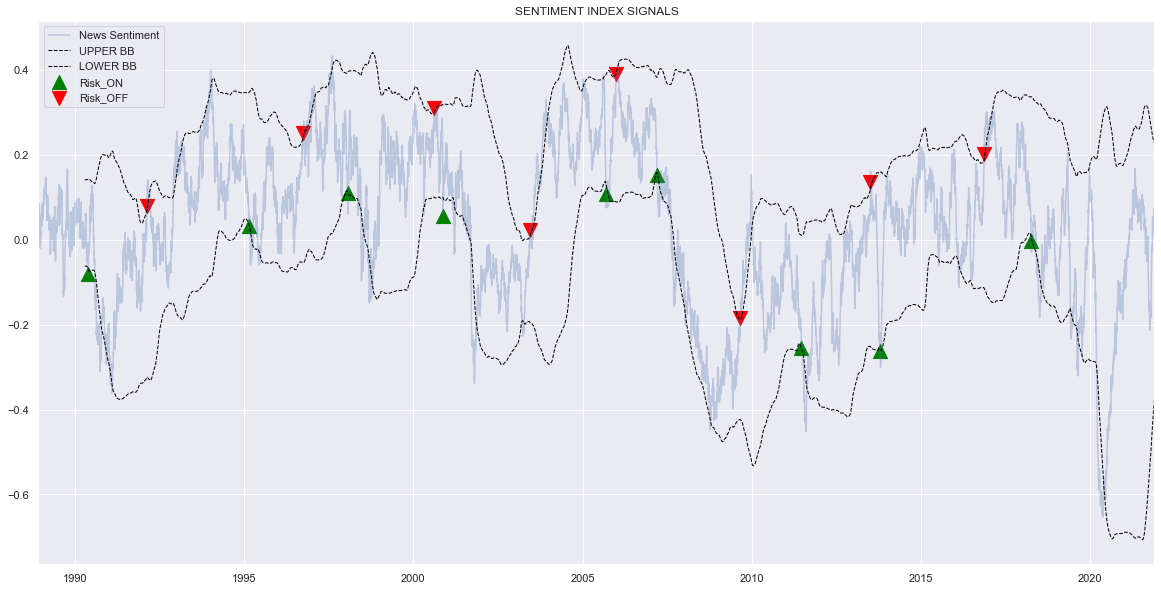

In [20]:
#Plotting the Signal lists

sentiment_index['News Sentiment'].plot(label = 'News Sentiment', alpha = 0.3, figsize=(20,10))
sentiment_index['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
sentiment_index['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(sentiment_index.index, risk_on, marker = '^', color = 'green', label = 'Risk_ON', s = 200)
plt.scatter(sentiment_index.index, risk_off, marker = 'v', color = 'red', label = 'Risk_OFF', s = 200)
plt.title('SENTIMENT INDEX SIGNALS')
plt.legend(loc = 'upper left')
plt.show()

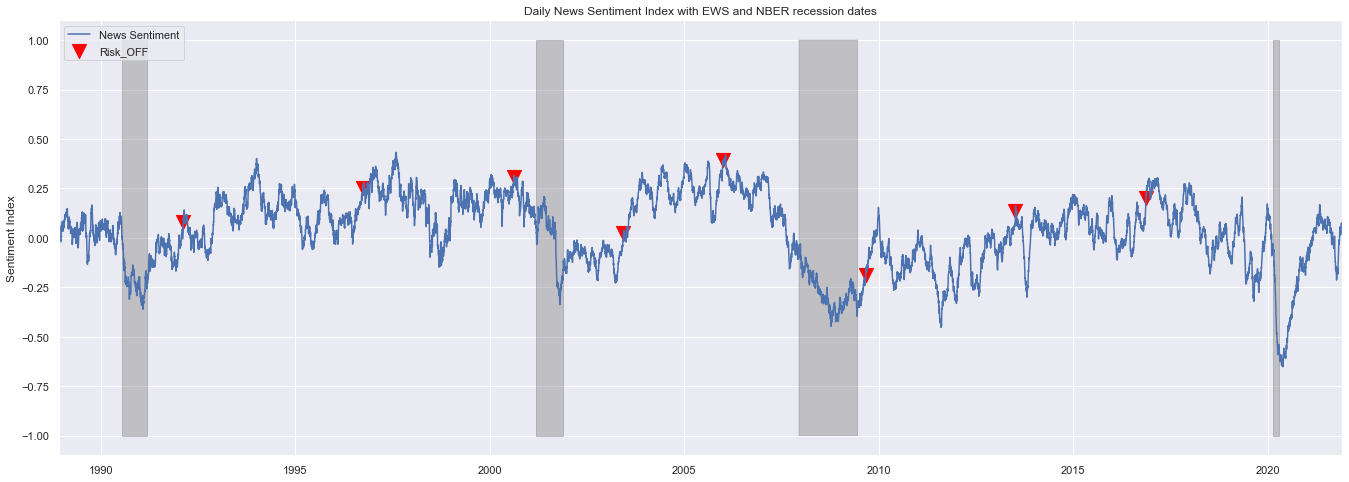

In [21]:
# To visually assess the effectiveness of our EWS

sentiment_index['News Sentiment'].plot(figsize=(23,8)).fill_between(sentiment_index.index,
                                                       -1,
                                                       1, 
                                                       where= sentiment_index['Recession Indicator'] > 0.5,
                color='grey', alpha=0.4)

plt.scatter(sentiment_index.index, risk_off, marker = 'v', color = 'red', label = 'Risk_OFF', s = 200)
plt.ylabel('Sentiment Index')
plt.title('Daily News Sentiment Index with EWS and NBER recession dates')
plt.legend(loc = 'upper left')
plt.show()

In [22]:
#Including the Bollinger-Band signals into our current dataframe

sentiment_index['bb_signal'] = bb_signal
sentiment_index

,News Sentiment,Recession Indicator,sma_500,upper_bb,lower_bb,bb_signal
1988-12-01,0.041998,0,NaN,NaN,NaN,0
1988-12-02,0.028742,0,NaN,NaN,NaN,0
1988-12-03,0.034444,0,NaN,NaN,NaN,0
1988-12-04,0.057563,0,NaN,NaN,NaN,0
1988-12-05,0.051180,0,NaN,NaN,NaN,0
...,...,...,...,...,...,...
2021-11-24,0.067577,0,-0.078027,0.230130,-0.386183,0
2021-11-25,0.055250,0,-0.077007,0.229524,-0.383537,0
2021-11-26,0.057000,0,-0.075950,0.228770,-0.380669,0
2021-11-27,0.040627,0,-0.074967,0.228072,-0.378005,0


In [23]:
sentiment_index.bb_signal.value_counts()

 0    12034
 1        9
-1        8
Name: bb_signal, dtype: int64

### Creating Positions

In [24]:
#Generate values for the ‘position’ list to just match the length of the ‘signal’ list
position = []
for i in range(len(bb_signal)):
    if bb_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
#The value of the position remains 1 if we hold the portfolio or remains 0 if we sold or don’t own the portfolio
for i in range(len(sentiment_index['News Sentiment'])):
    if bb_signal[i] == 1:
        position[i] = 1
    elif bb_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

In [25]:
#Including the portfolio positions into our current dataframe

sentiment_index['positions'] = position
sentiment_index

,News Sentiment,Recession Indicator,sma_500,upper_bb,lower_bb,bb_signal,positions
1988-12-01,0.041998,0,NaN,NaN,NaN,0,1
1988-12-02,0.028742,0,NaN,NaN,NaN,0,1
1988-12-03,0.034444,0,NaN,NaN,NaN,0,1
1988-12-04,0.057563,0,NaN,NaN,NaN,0,1
1988-12-05,0.051180,0,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...
2021-11-24,0.067577,0,-0.078027,0.230130,-0.386183,0,1
2021-11-25,0.055250,0,-0.077007,0.229524,-0.383537,0,1
2021-11-26,0.057000,0,-0.075950,0.228770,-0.380669,0,1
2021-11-27,0.040627,0,-0.074967,0.228072,-0.378005,0,1


In [26]:
sentiment_index.positions.value_counts()

1    7838
0    4213
Name: positions, dtype: int64

### Backtesting

#### Period 1:
26/11/1990 - 30/01/2003

In [27]:
#Reading the parity portfolio file for the first period

parity_portfolio_1 = pd.DataFrame(pd.read_csv('first.csv', index_col='Dates').Total)

In [28]:
#converting index to a datetime object
parity_portfolio_1.index = pd.to_datetime(parity_portfolio_1.index)
parity_portfolio_1 = parity_portfolio_1.rename(columns={"Total":"return_1"})
parity_portfolio_1

,return_1
Dates,
1990-11-26,0.000000
1990-11-27,0.000000
1990-11-28,-0.000000
1990-11-29,-0.000000
1990-11-30,0.000000
...,...
2003-01-24,-0.041121
2003-01-27,-0.069092
2003-01-28,0.006587


In [29]:
#Setting the start and end dates for the sample period 1
start_1 = parity_portfolio_1.index[0]
end_1 = parity_portfolio_1.index[-1]

In [30]:
#Slicing the sentiment index dataset into its respective timeframe
sentiment_index_1 = sentiment_index.copy()
sentiment_index_1 = sentiment_index.loc[start_1:end_1]
sentiment_index_1

,News Sentiment,Recession Indicator,sma_500,upper_bb,lower_bb,bb_signal,positions
1990-11-26,-0.262785,1,-0.027018,0.198402,-0.252438,0,1
1990-11-27,-0.270957,1,-0.027628,0.198777,-0.254034,0,1
1990-11-28,-0.242176,1,-0.028210,0.198903,-0.255323,0,1
1990-11-29,-0.232232,1,-0.028770,0.198973,-0.256513,0,1
1990-11-30,-0.239344,1,-0.029343,0.199074,-0.257760,0,1
...,...,...,...,...,...,...,...
2003-01-26,-0.040179,0,-0.111846,0.022324,-0.246015,0,1
2003-01-27,-0.035194,0,-0.111744,0.022581,-0.246069,0,1
2003-01-28,-0.057001,0,-0.111664,0.022744,-0.246072,0,1
2003-01-29,-0.061729,0,-0.111570,0.022912,-0.246052,0,1


In [31]:
#Appending the returns of the parity portfolio onto the sentiment index dataset
sentiment_index_1 = pd.concat([sentiment_index_1, parity_portfolio_1], axis=1)
sentiment_index_1

,News Sentiment,Recession Indicator,sma_500,upper_bb,lower_bb,bb_signal,positions,return_1
1990-11-26,-0.262785,1,-0.027018,0.198402,-0.252438,0,1,0.000000
1990-11-27,-0.270957,1,-0.027628,0.198777,-0.254034,0,1,0.000000
1990-11-28,-0.242176,1,-0.028210,0.198903,-0.255323,0,1,-0.000000
1990-11-29,-0.232232,1,-0.028770,0.198973,-0.256513,0,1,-0.000000
1990-11-30,-0.239344,1,-0.029343,0.199074,-0.257760,0,1,0.000000
...,...,...,...,...,...,...,...,...
2003-01-26,-0.040179,0,-0.111846,0.022324,-0.246015,0,1,NaN
2003-01-27,-0.035194,0,-0.111744,0.022581,-0.246069,0,1,-0.069092
2003-01-28,-0.057001,0,-0.111664,0.022744,-0.246072,0,1,0.006587
2003-01-29,-0.061729,0,-0.111570,0.022912,-0.246052,0,1,0.000629


In [32]:
#Dropping Nan values
sentiment_index_1 = sentiment_index_1.dropna()
sentiment_index_1

,News Sentiment,Recession Indicator,sma_500,upper_bb,lower_bb,bb_signal,positions,return_1
1990-11-26,-0.262785,1,-0.027018,0.198402,-0.252438,0,1,0.000000
1990-11-27,-0.270957,1,-0.027628,0.198777,-0.254034,0,1,0.000000
1990-11-28,-0.242176,1,-0.028210,0.198903,-0.255323,0,1,-0.000000
1990-11-29,-0.232232,1,-0.028770,0.198973,-0.256513,0,1,-0.000000
1990-11-30,-0.239344,1,-0.029343,0.199074,-0.257760,0,1,0.000000
...,...,...,...,...,...,...,...,...
2003-01-24,-0.043481,0,-0.111815,0.022431,-0.246061,0,1,-0.041121
2003-01-27,-0.035194,0,-0.111744,0.022581,-0.246069,0,1,-0.069092
2003-01-28,-0.057001,0,-0.111664,0.022744,-0.246072,0,1,0.006587
2003-01-29,-0.061729,0,-0.111570,0.022912,-0.246052,0,1,0.000629


In [33]:
#Loop for strategy return
bb_strategy_ret_1 = []

for i in range(len(sentiment_index_1)):
    try:
        returns = sentiment_index_1['return_1'][i] * sentiment_index_1['positions'][i-1]
        bb_strategy_ret_1.append(returns)
        
    except:
        pass

In [34]:
#Appending the strategy return list to the main dataframe

pd.set_option('mode.chained_assignment', None) #To turn off the 'settingwithcopy warning'

sentiment_index_1['strategy_ret_1'] = bb_strategy_ret_1
sentiment_index_1

,News Sentiment,Recession Indicator,sma_500,upper_bb,lower_bb,bb_signal,positions,return_1,strategy_ret_1
1990-11-26,-0.262785,1,-0.027018,0.198402,-0.252438,0,1,0.000000,0.000000
1990-11-27,-0.270957,1,-0.027628,0.198777,-0.254034,0,1,0.000000,0.000000
1990-11-28,-0.242176,1,-0.028210,0.198903,-0.255323,0,1,-0.000000,-0.000000
1990-11-29,-0.232232,1,-0.028770,0.198973,-0.256513,0,1,-0.000000,-0.000000
1990-11-30,-0.239344,1,-0.029343,0.199074,-0.257760,0,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2003-01-24,-0.043481,0,-0.111815,0.022431,-0.246061,0,1,-0.041121,-0.041121
2003-01-27,-0.035194,0,-0.111744,0.022581,-0.246069,0,1,-0.069092,-0.069092
2003-01-28,-0.057001,0,-0.111664,0.022744,-0.246072,0,1,0.006587,0.006587
2003-01-29,-0.061729,0,-0.111570,0.022912,-0.246052,0,1,0.000629,0.000629


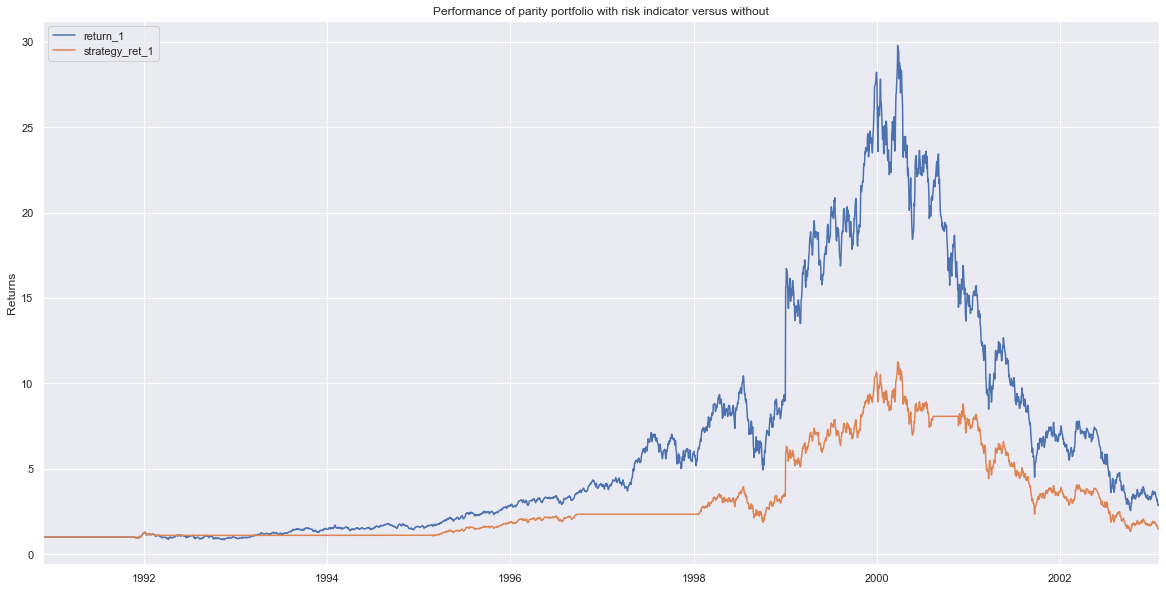

In [35]:
#Plotting the performance of our strategy

(sentiment_index_1.return_1 + 1).cumprod().plot(figsize=(20,10))
(sentiment_index_1.strategy_ret_1 + 1).cumprod().plot()
plt.ylabel('Returns')
plt.title('Performance of parity portfolio with risk indicator versus without')
plt.legend(loc = 'upper left')
plt.show()

#### Period 2:
03/02/2003 - 30/11/2021

In [36]:
#Reading the parity portfolio file for the second period

parity_portfolio_2 = pd.DataFrame(pd.read_csv('second.csv', index_col='Dates').Total)

In [37]:
#converting index to a datetime object
parity_portfolio_2.index = pd.to_datetime(parity_portfolio_2.index)
parity_portfolio_2 = parity_portfolio_2.rename(columns={"Total":"return_2"})
parity_portfolio_2

,return_2
Dates,
2003-02-03,0.000000
2003-02-04,0.000000
2003-02-05,0.000000
2003-02-06,-0.000000
2003-02-07,-0.000000
...,...
2021-11-24,-0.023335
2021-11-25,0.008779
2021-11-26,-0.047682


In [38]:
#Setting the start and end dates for the sample period 2
start_2 = parity_portfolio_2.index[0]
end_2 = parity_portfolio_2.index[-1]

In [39]:
#Slicing the sentiment index dataset into its respective timeframe
sentiment_index_2 = sentiment_index.copy()
sentiment_index_2 = sentiment_index.loc[start_2:end_2]
sentiment_index_2

,News Sentiment,Recession Indicator,sma_500,upper_bb,lower_bb,bb_signal,positions
2003-02-03,-0.066385,0,-0.110630,0.023538,-0.244798,0,1
2003-02-04,-0.068681,0,-0.110316,0.023508,-0.244141,0,1
2003-02-05,-0.080954,0,-0.110029,0.023429,-0.243487,0,1
2003-02-06,-0.077296,0,-0.109720,0.023323,-0.242764,0,1
2003-02-07,-0.084972,0,-0.109420,0.023168,-0.242008,0,1
...,...,...,...,...,...,...,...
2021-11-24,0.067577,0,-0.078027,0.230130,-0.386183,0,1
2021-11-25,0.055250,0,-0.077007,0.229524,-0.383537,0,1
2021-11-26,0.057000,0,-0.075950,0.228770,-0.380669,0,1
2021-11-27,0.040627,0,-0.074967,0.228072,-0.378005,0,1


In [40]:
#Appending the returns of the parity portfolio onto the sentiment index dataset
sentiment_index_2 = pd.concat([sentiment_index_2, parity_portfolio_2], axis=1)
sentiment_index_2

,News Sentiment,Recession Indicator,sma_500,upper_bb,lower_bb,bb_signal,positions,return_2
2003-02-03,-0.066385,0.0,-0.110630,0.023538,-0.244798,0.0,1.0,0.000000
2003-02-04,-0.068681,0.0,-0.110316,0.023508,-0.244141,0.0,1.0,0.000000
2003-02-05,-0.080954,0.0,-0.110029,0.023429,-0.243487,0.0,1.0,0.000000
2003-02-06,-0.077296,0.0,-0.109720,0.023323,-0.242764,0.0,1.0,-0.000000
2003-02-07,-0.084972,0.0,-0.109420,0.023168,-0.242008,0.0,1.0,-0.000000
...,...,...,...,...,...,...,...,...
2021-11-26,0.057000,0.0,-0.075950,0.228770,-0.380669,0.0,1.0,-0.047682
2021-11-27,0.040627,0.0,-0.074967,0.228072,-0.378005,0.0,1.0,NaN
2021-11-28,0.050691,0.0,-0.073947,0.227337,-0.375231,0.0,1.0,NaN
2021-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.017883


In [41]:
#Dropping Nan values
sentiment_index_2 = sentiment_index_2.dropna()
sentiment_index_2

,News Sentiment,Recession Indicator,sma_500,upper_bb,lower_bb,bb_signal,positions,return_2
2003-02-03,-0.066385,0.0,-0.110630,0.023538,-0.244798,0.0,1.0,0.000000
2003-02-04,-0.068681,0.0,-0.110316,0.023508,-0.244141,0.0,1.0,0.000000
2003-02-05,-0.080954,0.0,-0.110029,0.023429,-0.243487,0.0,1.0,0.000000
2003-02-06,-0.077296,0.0,-0.109720,0.023323,-0.242764,0.0,1.0,-0.000000
2003-02-07,-0.084972,0.0,-0.109420,0.023168,-0.242008,0.0,1.0,-0.000000
...,...,...,...,...,...,...,...,...
2021-11-22,0.067043,0.0,-0.080152,0.231175,-0.391478,0.0,1.0,-0.009911
2021-11-23,0.075003,0.0,-0.079080,0.230677,-0.388836,0.0,1.0,-0.005782
2021-11-24,0.067577,0.0,-0.078027,0.230130,-0.386183,0.0,1.0,-0.023335
2021-11-25,0.055250,0.0,-0.077007,0.229524,-0.383537,0.0,1.0,0.008779


In [42]:
#Loop for strategy return
bb_strategy_ret_2 = []

for i in range(len(sentiment_index_2)):
    try:
        returns = sentiment_index_2['return_2'][i] * sentiment_index_2['positions'][i-1]
        bb_strategy_ret_2.append(returns)
        
    except:
        pass

In [43]:
#Appending the strategy return list to the main dataframe

sentiment_index_2['strategy_ret_2'] = bb_strategy_ret_2
sentiment_index_2

,News Sentiment,Recession Indicator,sma_500,upper_bb,lower_bb,bb_signal,positions,return_2,strategy_ret_2
2003-02-03,-0.066385,0.0,-0.110630,0.023538,-0.244798,0.0,1.0,0.000000,0.000000
2003-02-04,-0.068681,0.0,-0.110316,0.023508,-0.244141,0.0,1.0,0.000000,0.000000
2003-02-05,-0.080954,0.0,-0.110029,0.023429,-0.243487,0.0,1.0,0.000000,0.000000
2003-02-06,-0.077296,0.0,-0.109720,0.023323,-0.242764,0.0,1.0,-0.000000,-0.000000
2003-02-07,-0.084972,0.0,-0.109420,0.023168,-0.242008,0.0,1.0,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...
2021-11-22,0.067043,0.0,-0.080152,0.231175,-0.391478,0.0,1.0,-0.009911,-0.009911
2021-11-23,0.075003,0.0,-0.079080,0.230677,-0.388836,0.0,1.0,-0.005782,-0.005782
2021-11-24,0.067577,0.0,-0.078027,0.230130,-0.386183,0.0,1.0,-0.023335,-0.023335
2021-11-25,0.055250,0.0,-0.077007,0.229524,-0.383537,0.0,1.0,0.008779,0.008779


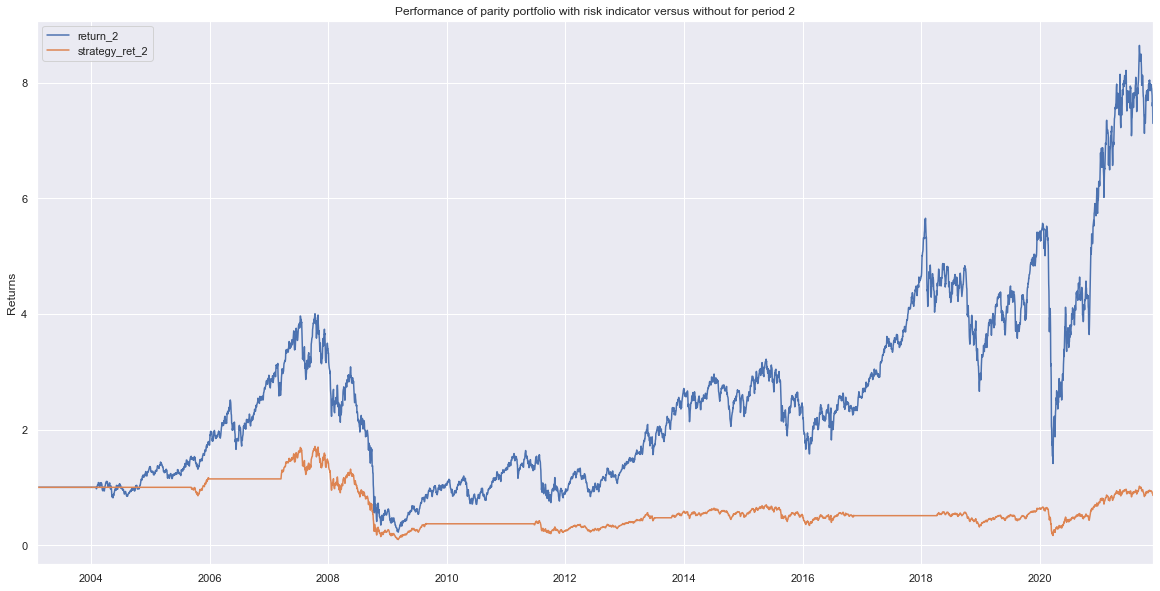

In [44]:
#Plotting the performance of our strategy for the second period

(sentiment_index_2.return_2 + 1).cumprod().plot(figsize=(20,10))
(sentiment_index_2.strategy_ret_2 + 1).cumprod().plot()
plt.ylabel('Returns')
plt.title('Performance of parity portfolio with risk indicator versus without for period 2')
plt.legend(loc = 'upper left')
plt.show()